In [ ]:
pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

#Material Requirements planning (MRP)
Bill of material :

Parent: FP , A

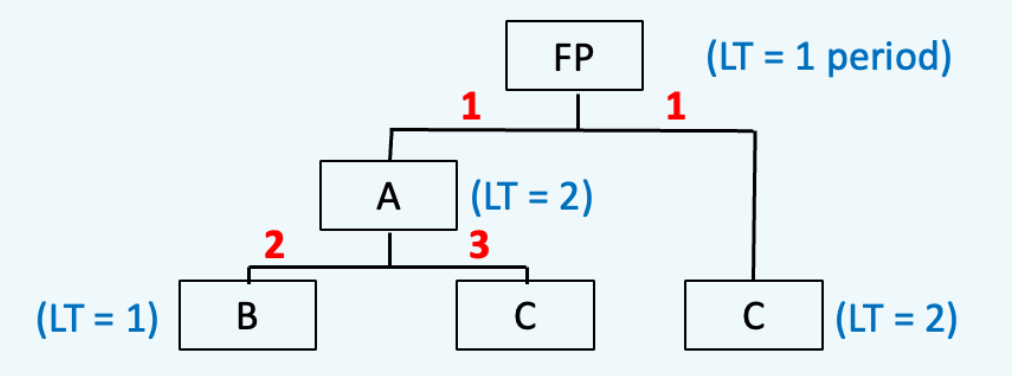
Child (P) : A, B, c

Quantity (r) = 1, 1, 2

In [ ]:
class data_generator():

    def __init__(self):

        self.months = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
        self.demands = [[0, 95, 200, 96, 86, 124, 83, 108, 114, 121, 110, 124, 104, 86, 87],
                        [0, 95, 200, 96, 86, 124, 83, 108, 114, 121, 110, 124, 104, 86, 87],
                        [0, 190, 400, 192, 172, 248, 166, 216, 228, 242, 220, 248, 208, 172, 174],
                        [0, 380, 800, 384, 344, 496, 332, 432, 456, 484, 440, 496, 416, 344, 348]]
        #Costs for finished produced and components
        self.prod_cost = 100 #for all products
        self.setup_cost = 5000 #per unit for all products
        self.holding_cost = 5 #per unit for all products



        self.safety_stock = [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item FP
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item A
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item B
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # for item C
    ]
        self.first_inventory = [200, 500, 500, 500]

        self.BOM = {
            0: [(1, 1), (3, 1)],   # FP → A (1), C (1)
            1: [(2, 2), (3, 3)],   # A → B (2), C (3)
            2: [],                # B → nothing
            3: []                 # C → nothing
        }
        self.lead_time = [1, 2, 1, 2]
        self.alpha = [0, 4.5, 0, 0]
        self.beta = [0, 85, 0, 0]
        self.time_capacity = [0, 2136, 0, 0]

Add a helper function to compute total demand per item

This is where the main change happens. Add this helper function inside optimal_production_1:

In [ ]:
from ortools.linear_solver import pywraplp

def optimal_production_1(data):
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    setup, production, inventory = [], [], []
    for i in range(len(data.demands)):
        setup_temp, production_temp, inventory_temp = [], [], []
        for t in range(len(data.months)):
            suffix = f'_{i}_{t}'
            setup_temp.append(m.BoolVar('setup' + suffix))
            production_temp.append(m.IntVar(0, 100000, 'production' + suffix))
            inventory_temp.append(m.IntVar(0, 100000, 'inventory' + suffix))
        setup.append(setup_temp)
        production.append(production_temp)
        inventory.append(inventory_temp)

    # === Define helper inside ===
    def compute_total_demand(item_idx, t):
        d_ex = data.demands[0][t] if item_idx == 0 else 0
        internal = 0
        for parent_idx in range(len(data.BOM)):
            for (comp_idx, coeff) in data.BOM[parent_idx]:
                if comp_idx == item_idx:
                    internal += coeff * production[parent_idx][t]
        return d_ex + internal

    # === Constraints ===
    for item_idx in range(len(data.BOM)):
        for t in range(len(data.months)):
            inv_before = data.first_inventory[item_idx] if t == 0 else inventory[item_idx][t - 1]
            prod_time = t - data.lead_time[item_idx]
            prod = production[item_idx][prod_time] if prod_time >= 0 else m.NumVar(0, 0, f'dummy_zero_{item_idx}_{t}')
            total_demand = compute_total_demand(item_idx, t)
            m.Add(inv_before + prod == total_demand + inventory[item_idx][t])

    for i in range(len(data.demands)):
        for t in range(len(data.months)):
            m.Add(production[i][t] <= (sum(data.demands[i][t:]) + sum(data.safety_stock[i][t:])) * setup[i][t])
            m.Add(inventory[i][t] >= data.safety_stock[i][t])

            m.Add(data.alpha[i] * production[i][t] + data.beta[i]* setup[i][t] <= data.time_capacity[i])

    # Objective
    total_cost = m.Sum(
        production[i][t] * data.prod_cost +
        setup[i][t] * data.setup_cost +
        inventory[i][t] * data.holding_cost
        for i in range(len(data.demands))
        for t in range(len(data.months))
    )
    obj = m.NumVar(0, 1_000_000, 'obj')
    m.Add(obj >= total_cost)
    m.Minimize(obj)

    # Solve
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        PRODUCTION_PLAN = {}
        for i in range(len(data.demands)):
            PRODUCTION_PLAN_temp = {}
            for m_idx, month in enumerate(data.months):
                PRODUCTION_PLAN_temp[month] = {
                    'production': production[i][m_idx].solution_value(),
                    'setup': setup[i][m_idx].solution_value(),
                    'inventory': inventory[i][m_idx].solution_value()
                }
            PRODUCTION_PLAN[i] = PRODUCTION_PLAN_temp

        return PRODUCTION_PLAN, m.Objective().Value(), setup, production, inventory

    else:
        print('The problem does not have an optimal solution.')
        return None, None, None, None, None


In [ ]:
from IPython.display import display, Markdown


# Run the model
data = data_generator()
PRODUCTION_PLAN, obj, setup_vars, production_vars, inventory_vars = optimal_production_1(data)

if PRODUCTION_PLAN:
    display(Markdown("### Production Plan FP"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).round(0))

    display(Markdown("### Production Plan A"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[1]).round(0))

    display(Markdown("### Production Plan B"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[2]).round(0))

    display(Markdown("### Production Plan C"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[3]).round(0))

    print('Objective is:', round(obj))





### Production Plan FP

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,500.0,0.0,0.0,0.0,0.0,0.0,838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,200.0,605.0,405.0,309.0,223.0,99.0,16.0,746.0,632.0,511.0,401.0,277.0,173.0,87.0,0.0


### Production Plan A

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,0.0,0.0,0.0,425.0,413.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Production Plan B

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,0.0,0.0,1176.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
setup,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
inventory,500.0,500.0,500.0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Production Plan C

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,0.0,1275.0,1239.0,0.0,838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
setup,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
inventory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Objective is: 747575


In [ ]:
months = data.months
prod_lp = [PRODUCTION_PLAN[1][t]['production'] for t in months]
inv_lp = [PRODUCTION_PLAN[1][t]['inventory'] for t in months]
lead_time_lp = data.lead_time[1]  # usually 1

In [ ]:
received_lp = [1] * len(months)
for t in range(len(months)):
    prod_time = t - lead_time_lp
    if prod_time >= 0:
        received_lp[t] = prod_lp[prod_time]

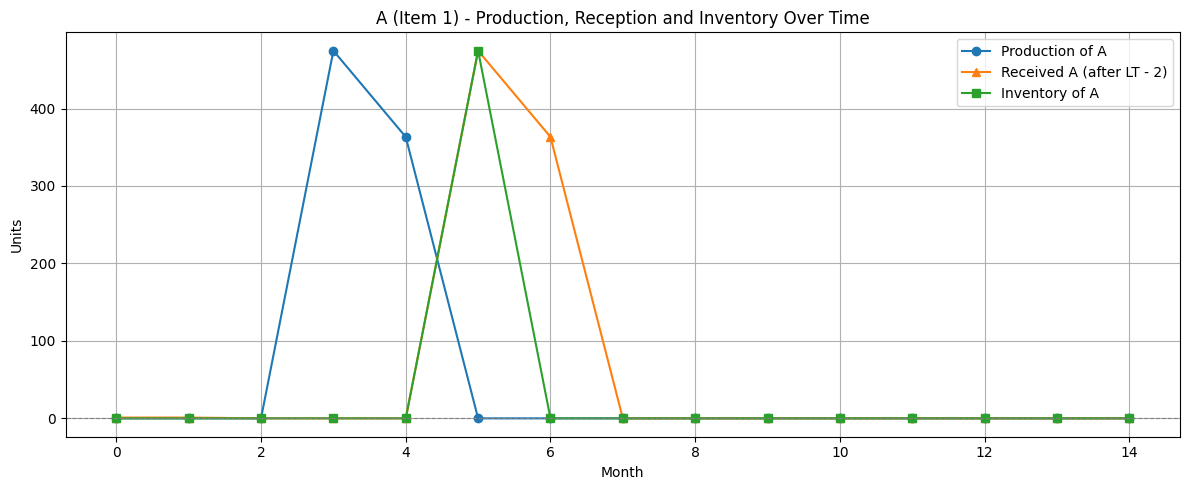

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(months, prod_lp, label='Production of A', marker='o')
plt.plot(months, received_lp, label='Received A (after LT - 2)', marker='^')
plt.plot(months, inv_lp, label='Inventory of A', marker='s')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Month')
plt.ylabel('Units')
plt.title('A (Item 1) - Production, Reception and Inventory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
months = data.months
prod_lp = [PRODUCTION_PLAN[2][t]['production'] for t in months]
inv_lp = [PRODUCTION_PLAN[2][t]['inventory'] for t in months]
lead_time_lp = data.lead_time[2]
received_lp = [2] * len(months)
for t in range(len(months)):
    prod_time = t - lead_time_lp
    if prod_time >= 0:
        received_lp[t] = prod_lp[prod_time]

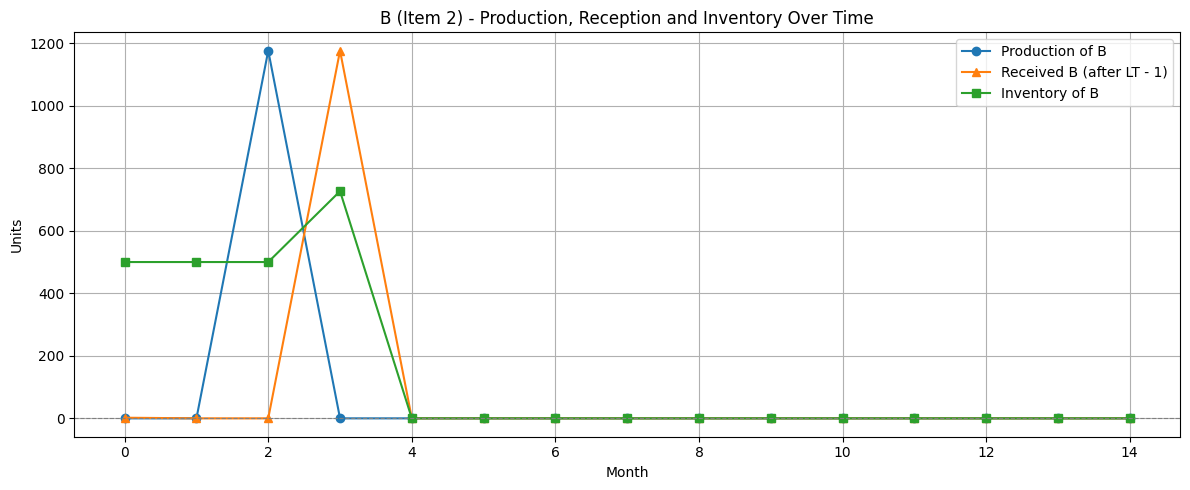

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(months, prod_lp, label='Production of B', marker='o')
plt.plot(months, received_lp, label='Received B (after LT - 1)', marker='^')
plt.plot(months, inv_lp, label='Inventory of B', marker='s')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Month')
plt.ylabel('Units')
plt.title('B (Item 2) - Production, Reception and Inventory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


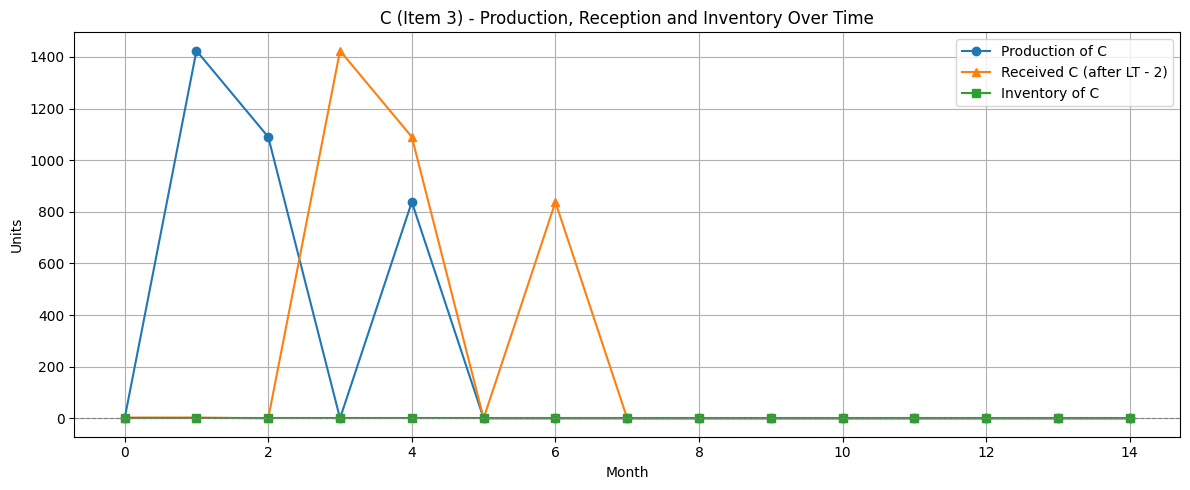

In [ ]:
months = data.months
prod_lp = [PRODUCTION_PLAN[3][t]['production'] for t in months]
inv_lp = [PRODUCTION_PLAN[3][t]['inventory'] for t in months]
lead_time_lp = data.lead_time[3]
received_lp = [3] * len(months)
for t in range(len(months)):
    prod_time = t - lead_time_lp
    if prod_time >= 0:
        received_lp[t] = prod_lp[prod_time]

plt.figure(figsize=(12, 5))
plt.plot(months, prod_lp, label='Production of C', marker='o')
plt.plot(months, received_lp, label='Received C (after LT - 2)', marker='^')
plt.plot(months, inv_lp, label='Inventory of C', marker='s')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Month')
plt.ylabel('Units')
plt.title('C (Item 3) - Production, Reception and Inventory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

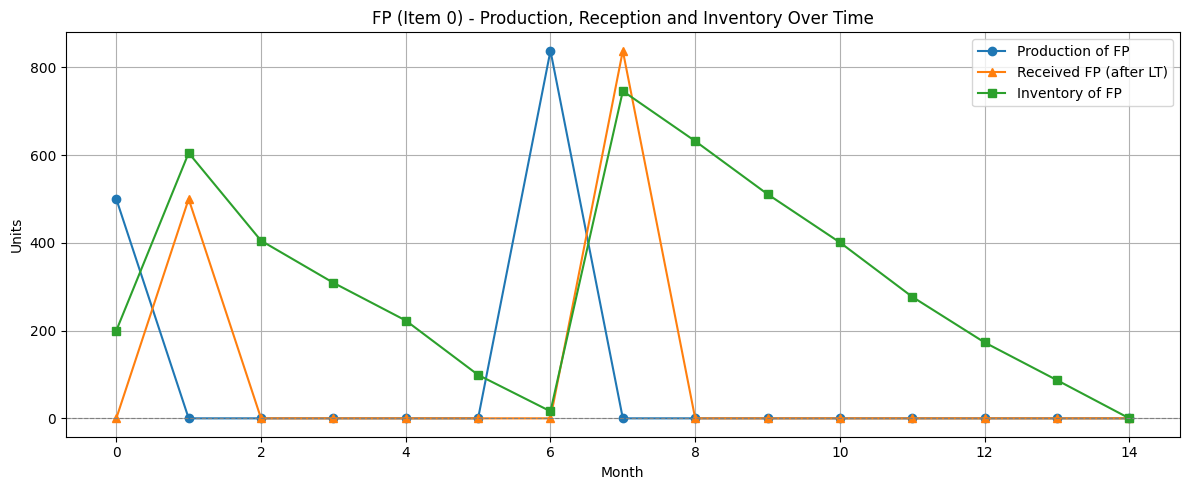

In [ ]:
months = data.months
prod_lp = [PRODUCTION_PLAN[0][t]['production'] for t in months]
inv_lp = [PRODUCTION_PLAN[0][t]['inventory'] for t in months]
lead_time_lp = data.lead_time[0]
received_lp = [0] * len(months)
for t in range(len(months)):
    prod_time = t - lead_time_lp
    if prod_time >= 0:
        received_lp[t] = prod_lp[prod_time]

plt.figure(figsize=(12, 5))
plt.plot(months, prod_lp, label='Production of FP', marker='o')
plt.plot(months, received_lp, label='Received FP (after LT)', marker='^')
plt.plot(months, inv_lp, label='Inventory of FP', marker='s')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Month')
plt.ylabel('Units')
plt.title('FP (Item 0) - Production, Reception and Inventory Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class data_generator_2():

    def __init__(self):

        self.months = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
        self.demands = [[0, 95, 200, 96, 86, 124, 83, 108, 114, 121, 110, 124, 104, 86, 87],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
        #Costs for finished produced and components
        self.prod_cost = 100 #for all products
        self.setup_cost = 5000 #per unit for all products
        self.holding_cost = 5 #per unit for all products



        self.safety_stock = [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item FP
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item A
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # for item B
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   # for item C
    ]
        self.first_inventory = [200, 500, 500, 500]

        self.BOM = {
            0: [(1, 1), (3, 1)],   # FP → A (1), C (1)
            1: [(2, 2), (3, 3)],   # A → B (2), C (3)
            2: [],                # B → nothing
            3: []                 # C → nothing
        }
        self.lead_time = [1, 2, 1, 2]
        self.alpha_cutting = [0, 1.5, 0, 0]
        self.beta_cutting = [0, 25, 0, 0]
        self.time_capacity_cutting = [0, 456, 0, 0]

        self.alpha_transfer = [0, 0, 0, 0]
        self.beta_transfer = [0, 20, 0, 0]
        self.time_capacity_transfer = [0, 408, 0, 0]

        self.alpha_assembling = [0, 0.5, 0, 0]
        self.beta_assembling = [0, 10, 0, 0]
        self.time_capacity_assembling = [0, 816, 0, 0]

        self.alpha_painting = [0, 2.5, 0, 0]
        self.beta_painting = [0, 30, 0, 0]
        self.time_capacity_painting = [0, 456, 0, 0]

In [ ]:
from ortools.linear_solver import pywraplp

def optimal_production_1(data):
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Decision variables
    setup, production, inventory = [], [], []
    for i in range(len(data.demands)):
        setup_temp, production_temp, inventory_temp = [], [], []
        for t in range(len(data.months)):
            suffix = f'_{i}_{t}'
            setup_temp.append(m.BoolVar('setup' + suffix))
            production_temp.append(m.IntVar(0, 100000, 'production' + suffix))
            inventory_temp.append(m.IntVar(0, 100000, 'inventory' + suffix))
        setup.append(setup_temp)
        production.append(production_temp)
        inventory.append(inventory_temp)

    # === Define helper inside ===
    def compute_total_demand(item_idx, t):
        d_ex = data.demands[0][t] if item_idx == 0 else 0
        internal = 0
        for parent_idx in range(len(data.BOM)):
            for (comp_idx, coeff) in data.BOM[parent_idx]:
                if comp_idx == item_idx:
                    internal += coeff * production[parent_idx][t]
        total_demand = d_ex + internal

        # Print the computed total demand for each product at each time
        #print(f"Total demand for product {item_idx} at time {t}: {total_demand} (External: {d_ex}, Internal: {internal})")

        return total_demand

    # === Constraints ===
    for item_idx in range(len(data.BOM)):
        for t in range(len(data.months)):
            inv_before = data.first_inventory[item_idx] if t == 0 else inventory[item_idx][t - 1]
            prod_time = t - data.lead_time[item_idx]
            prod = production[item_idx][prod_time] if prod_time >= 0 else 0
            total_demand = compute_total_demand(item_idx, t)
            m.Add(inv_before + prod == total_demand + inventory[item_idx][t])

    for i in range(len(data.demands)):
        for t in range(len(data.months)):
            #m.Add(production[i][t] <= (sum(data.demands[i][t:]) + sum(data.safety_stock[i][t:])) * setup[i][t])
            m.Add(production[i][t] <= 100000 * setup[i][t])
            m.Add(inventory[i][t] >= data.safety_stock[i][t])

   # Capacity constraints for each stage
    for i in range(len(data.demands)):
        for t in range(len(data.months)):
            # Cutting stage
            m.Add(data.alpha_cutting[i] * production[i][t] + data.beta_cutting[i] * setup[i][t] <= data.time_capacity_cutting[i])
            # Transfer stage
            m.Add(data.alpha_transfer[i] * production[i][t] + data.beta_transfer[i] * setup[i][t] <= data.time_capacity_transfer[i])
            # Assembling stage
            m.Add(data.alpha_assembling[i] * production[i][t] + data.beta_assembling[i] * setup[i][t] <= data.time_capacity_assembling[i])
            # Painting stage
            m.Add(data.alpha_painting[i] * production[i][t] + data.beta_painting[i] * setup[i][t] <= data.time_capacity_painting[i])


    # Objective
    total_cost = m.Sum(
        production[i][t] * data.prod_cost +
        setup[i][t] * data.setup_cost +
        inventory[i][t] * data.holding_cost
        for i in range(len(data.demands))
        for t in range(len(data.months))
    )
    obj = m.NumVar(0, 1_000_000, 'obj')
    m.Add(obj >= total_cost)
    m.Minimize(obj)

    # Solve
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        PRODUCTION_PLAN = {}
        for i in range(len(data.demands)):
            PRODUCTION_PLAN_temp = {}
            for m_idx, month in enumerate(data.months):
                PRODUCTION_PLAN_temp[month] = {
                    'production': production[i][m_idx].solution_value(),
                    'setup': setup[i][m_idx].solution_value(),
                    'inventory': inventory[i][m_idx].solution_value()
                }
            PRODUCTION_PLAN[i] = PRODUCTION_PLAN_temp

        return PRODUCTION_PLAN, m.Objective().Value(), setup, production, inventory

    else:
        print('The problem does not have an optimal solution.')
        return None, None, None, None, None


In [ ]:
from IPython.display import display, Markdown


# Run the model
data = data_generator_2()
PRODUCTION_PLAN, obj, setup_vars, production_vars, inventory_vars = optimal_production_1(data)

if PRODUCTION_PLAN:
    display(Markdown("### Production Plan FP"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[0]).round(0))

    display(Markdown("### Production Plan A"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[1]).round(0))

    display(Markdown("### Production Plan B"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[2]).round(0))

    display(Markdown("### Production Plan C"))
    display(pd.DataFrame.from_dict(PRODUCTION_PLAN[3]).round(0))

    print('Objective is:', round(obj))





Total demand for product 0 at time 0: 0 (External: 0, Internal: 0)
Total demand for product 0 at time 1: 95 (External: 95, Internal: 0)
Total demand for product 0 at time 2: 200 (External: 200, Internal: 0)
Total demand for product 0 at time 3: 96 (External: 96, Internal: 0)
Total demand for product 0 at time 4: 86 (External: 86, Internal: 0)
Total demand for product 0 at time 5: 124 (External: 124, Internal: 0)
Total demand for product 0 at time 6: 83 (External: 83, Internal: 0)
Total demand for product 0 at time 7: 108 (External: 108, Internal: 0)
Total demand for product 0 at time 8: 114 (External: 114, Internal: 0)
Total demand for product 0 at time 9: 121 (External: 121, Internal: 0)
Total demand for product 0 at time 10: 110 (External: 110, Internal: 0)
Total demand for product 0 at time 11: 124 (External: 124, Internal: 0)
Total demand for product 0 at time 12: 104 (External: 104, Internal: 0)
Total demand for product 0 at time 13: 86 (External: 86, Internal: 0)
Total demand for

### Production Plan FP

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,500.0,0.0,0.0,0.0,-0.0,0.0,327.0,0.0,0.0,511.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0
inventory,200.0,605.0,405.0,309.0,223.0,99.0,16.0,235.0,121.0,0.0,401.0,277.0,173.0,87.0,0.0


### Production Plan A

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,0.0,0.0,170.0,0.0,170.0,158.0,170.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,-0.0,170.0,170.0,13.0,171.0,341.0,0.0,0.0,0.0,0.0,0.0,0.0


### Production Plan B

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,0.0,0.0,0.0,496.0,0.0,680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
setup,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
inventory,500.0,500.0,160.0,160.0,316.0,0.0,340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Production Plan C

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
production,510.0,0.0,984.0,0.0,1347.0,0.0,0.0,511.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
setup,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
inventory,0.0,0.0,-0.0,0.0,474.0,0.0,510.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


Objective is: 775280
